In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os 
from sqlalchemy import create_engine #databse connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
# EDA
# Creating db file from csv
if not os.path.isfile("train.db"):
    start = datetime.now()
    disk_engine = create_engine("sqlite:///train.db")
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv("Train.csv", names=["Id", "Title", "Body", "Tags"], chunksize=chunksize, iterator=True, encoding="utf-8"):
        df.index += index_start
        j += 1
        print("{} rows".format(j*chunksize))
        df.to_sql("data", disk_engine, if_exists="append")
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

In [3]:
# Counting the number of wos
if os.path.isfile("train.db"):
    start = datetime.now()
    con = sqlite3.connect("train.db")
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    # Always remember to close the database
    print("Number of rows in the database :", "\n", num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows: ", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to generate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows:  0:00:02.605098


In [4]:
# Checking for duplicates
if os.path.isfile("train.db"):
    start = datetime.now()
    con = sqlite3.connect("train.db")
    df_no_dup = pd.read_sql_query("""SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags""", con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to generate train.db file")

Time taken to run this cell : 0:03:21.206072


In [5]:
df_no_dup.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [6]:
print("number of duplicate questions : ", num_rows["count(*)"].values[0] - df_no_dup.shape[0], "(", (1-((df_no_dup.shape[0])/(num_rows["count(*)"].values[0])))*100, "% )")

number of duplicate questions :  1827881 ( 30.292038906260256 % )


In [7]:
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [8]:
df_no_dup["Tags"][0].split(" ")

['c++', 'c']

In [9]:
#df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))

In [10]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")) if text else 0)
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:01.930489


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [11]:
# distribution of number of tags per question
df_no_dup["tag_count"].value_counts()

3    1206157
2    1111706
4     814996
1     568291
5     505158
0          7
Name: tag_count, dtype: int64

In [12]:
# Creating a new databse with no duplicates
if not os.path.isfile("train_no_dup.db"):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=["Title", "Body", "Tags"])
    no_dup.to_sql('no_dup_train', disk_dup)

In [13]:
# This method seems more appropriate to work with this much data
# creating the connection with database file
if os.path.isfile("train_no_dup.db"):
    start = datetime.now()
    con = sqlite3.connect("train_no_dup.db")
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    # Always remember to close the database
    con.close()
    
    # Let's now drop unwanted column
    tag_data.drop(tag_data.index[0], inplace=True)
    # Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell: ", datetime.now() - start)
else:
    print("Download")

Time taken to run this cell:  0:00:31.327292


In [14]:
# yourResult = [str(sentence).split(' ') for sentence in tag_data["Tags"]]
# vectorizer = CountVectorizer()
# tag_dtm = vectorizer.fit_transform(yourResult)

In [15]:
tag_data["Tags"]

1                  c# silverlight data-binding
2          c# silverlight data-binding columns
3                                     jsp jstl
4                                    java jdbc
5                facebook api facebook-php-sdk
                          ...                 
4206310             wordpress wordpress-plugin
4206311                         php mysql text
4206312     php codeigniter character-encoding
4206313                 php email outlook mime
4206314                                   html
Name: Tags, Length: 4206314, dtype: object

In [16]:
# Analysis of tags
# vectorizer = CountVectorizer(tokenizer = lambda x: x.split() if x else "")
# tag_dtm = vectorizer.fit_transform(tag_data["Tags"])

In [17]:
# print("Number of data points: ", tag_dtm.shape[0])
# print("Number of unique tags: ", tag_dtm.shape[1])

In [18]:
# tags = vectorizer.get_feature_names()
# print("Some of the tags we have: ", tags[:10])

In [19]:
# freqs = tag_dtm.sum(axis = 0).A1
# result(dict(zip(tags, freqs)))

In [37]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [21]:
tag_df_sorted = tag_df.sort_values(["Counts"], ascending=False)
tag_counts = tag_df_sorted["Counts"].values

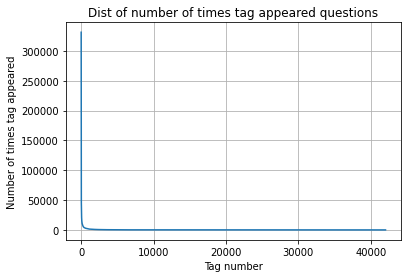

In [22]:
plt.plot(tag_counts)
plt.title("Dist of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

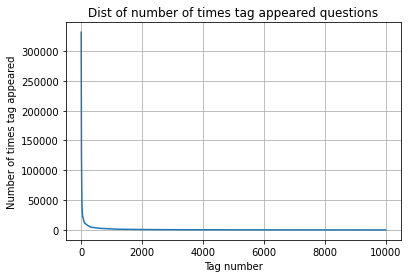

In [23]:
plt.plot(tag_counts[0:10000])
plt.title("Dist of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

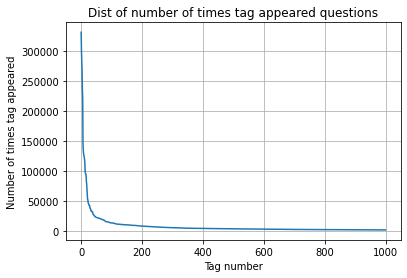

In [24]:
plt.plot(tag_counts[0:1000])
plt.title("Dist of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

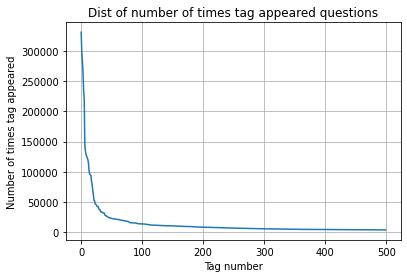

In [25]:
plt.plot(tag_counts[0:500])
plt.title("Dist of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

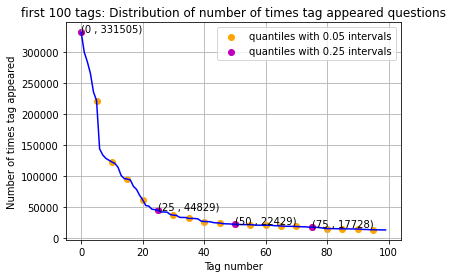

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [26]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [27]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


In [29]:
# tag_quest_count = tag_dtm.sum(axis=1).tolist()
# tag_quest_count = [int(j) for i in tag_quest_count for j in i]
# print("We have total {} datapoints.".format(len(tag_quest_count)))
# print(tag_quest_count[:5])

In [31]:
# print("Max number of tags per question: %d"%max(tag_quest_count))
# print("Min number of tags per question: %d"%min(tag_quest_count))
# print("Avg number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

In [32]:
# sns.countplot(tag_quest_count, palette="gist_rainbow")
# plt.title("Number of tags in the questions")
# plt.xlabel("Number of tags")
# plt.ylabel("Number of questions")
# plt.show()

In [33]:
# # Plotting word cloud
# start = datetime.now()

# # Lets first convert the 'result' dictionary to 'list of tuples'
# tup = dict(result.items())
# # Initializing WorldCloud using frequencies of tags
# wordcloud = WordCloud(background_color = "black",
#                       width = 1600, height = 800).generate_from_frequencies(tup)

# fig = plt.figure(figsize=(30,20))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad=0)
# fig.savefig("tag.png")
# plt.show()
# print("Time taken to run this cell :", datetime.now() - start)

In [39]:
# # The top 20 tags
# i = np.arange(30)
# tag_df_sorted.head(30).plot(kind="bar")
# plt.title("Frequency of top 20 tags")
# plt.xticks(i, tag_df_sorted["Tags"])
# plt.xlabel("Tags")
# plt.ylabel("Counts")
# plt.show()

In [47]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brijrajsinhgohil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brijrajsinhgohil/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
def striphtml(data):
    cleanr = re.compile("<.*?>")
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

In [44]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [45]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:22.811484


In [48]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1285
Avg. length of questions(Title+Body) after processing: 343
Percent of questions containing code: 58
Time taken to run this cell : 0:00:01.206595


In [49]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [50]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('child parent simultan resiz tri make simpl pictur resize web howev got one problem everyth work fine tri resiz parent anoth stori tri also resiz child part code whole code long hope enough help nso thing tri resiz child want chang order resiz first child parent abl resiz anyth anyon tell wrong',)
----------------------------------------------------------------------------------------------------
('need help figur issu updat problem updat record use cakephp second time happen cant figur click submit updat record alway alway send login either log log dont understand never updat record jump login stuff registr page thing work thing chang app control instead specifi control allow ad allow updat save anyth reason page page contact us page us also block auth went away app control set allow everyth filter also control beforefilt say thing tri everyth code app control one control updat view submit button pleas help solv issu research went cakephp cookbook noth',)

In [51]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [52]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 997
number of dimensions : 2


In [53]:
# Machine Learning models
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [54]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn = multilabel_y[:, sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [59]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

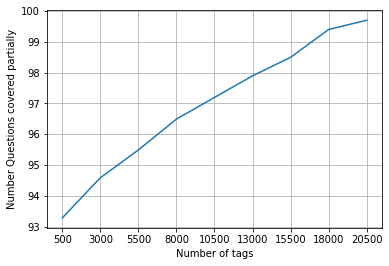

In [60]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50, 450, 50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions covered partially")
plt.grid()
plt.show()


In [61]:
multilabel_yx = tags_to_choose(5500)
print("Number of questions that are not covered: ", questions_explained_fn(5500), "out of", total_qs)

Number of questions that are not covered:  0 out of 997


In [62]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("Number of tags taken: ", multilabel_yx.shape[1], "(", (multilabel_yx.shape[1]/multilabel_y.shape[1])*100, "%)")

Number of tags in sample : 1386
Number of tags taken:  1386 ( 100.0 %)


In [63]:
total_size = preprocessed_data.shape[0]
train_size = int(0.80*total_size)

x_train = preprocessed_data.head(train_size)
x_test = preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [64]:
print("Number of data points in train data: ", y_train.shape)
print("Number of data points in test data: ", y_test.shape)

Number of data points in train data:  (797, 1386)
Number of data points in test data:  (200, 1386)


In [66]:
# Featurizing data
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train["question"])
x_test_multilabel = vectorizer.transform(x_test["question"])
print("Time taken to run this cell : ", datetime.now() - start)

Time taken to run this cell :  0:00:00.287751
